In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
#input_file = "./output_20200219_2125PM.csv"
input_file_1 = "../data/exogeni/output_20210207_1732PM/output_20210207_1732PM.csv" #OSG Full 1
input_file_2 = "../data/exogeni/output_20210209_2205PM/output_20210209_2205PM.csv" #OSG Full 2
input_file_3 = "../data/exogeni/output_20210213_0053AM/output_20210213_0053AM.csv" #OSG Full 3

partial_file_1 = "../data/exogeni/output_20210305_0317AM/output_20210305_0317AM.csv" #OSG Partial 1
partial_file_2 = "../data/exogeni/output_20210312_1757PM/output_20210312_1757PM.csv" #OSG Partial 2
partial_file_3 = "../data/exogeni/output_20210314_1541PM/output_20210314_1541PM.csv" #OSG Partial 3

input_file_list=[input_file_1,input_file_2,input_file_3]
partial_file_list=[partial_file_1,partial_file_2,partial_file_3]

#df = pd.read_csv(partial_file_2, header = 0)

In [3]:
def count_class(df,df_p, target_key):
    # summarize the class distribution
    if target_key=='index':
        target = df.index.to_series()
        target_p = df_p.index.to_series()
    else:
        target = df[target_key]
        target_p = df_p[target_key]
        
    counter = Counter(target)
    counter_p = Counter(target_p)
    print("df %d: df_p %d " % (len(counter),len(counter_p)))
    if len(counter)==len(counter_p):
        compare = target.compare(target_p)      
        print(compare)
    #for k,v in counter.items():
    #    per = v / len(target) * 100
        #print('Class=%s, Count=%d, Percentage=%.3f%%' % (k, v, per))
    #df_c=df[(df['LABEL']==k)]
    #fm=df_c['FM'].value_counts()
    #s=sum(fm)
    #for l,n in fm.items():
    #    print((l,n,n/s))
    
    return counter, counter_p

In [4]:
def file_process(data_file, info=False):
    input_file = data_file
    df = pd.read_csv(input_file, header = 0, dtype={'LABEL': 'str'})
    #df.dropna(inplace = True) 
    df.fillna(1.0/500.0) #the corruption rate for the cache failures is all set to be "NaN"
    df['LABEL']=df['LABEL'].str.replace('-','.')
    df['FLOW'] = df['SRCNODE']+'-'+df['DESTNODE']
    df['FM']=df['FAILURE']+df['MISSING']
    
    df_failure = df[ (df.FM==1)]
    df_dummy = pd.get_dummies(df_failure[['SRCNODE', 'DESTNODE','SRC_R','DEST_S','FLOW','FM','RETRIES','FILESIZE','THROUGHPUT','LABEL']], prefix=['SRC', 'DEST','SRC_R','DEST_S','FLOW'], columns=['SRCNODE', 'DESTNODE','SRC_R','DEST_S','FLOW'])
    df_dummy = df_dummy.replace(np.nan, 0, regex=True)
    y_complete=df_dummy['LABEL']
    X_complete=df_dummy.drop(['LABEL'],axis=1)
    
    if info:
        original_headers = list(df.columns.values)
        print("Original shape:")
        print(original_headers)
        print("Original shape:"+str(df.shape))
        dummy_headers = list(df_dummy.columns.values)
        print("Encoded shape:")
        print(dummy_headers)
        print(str(df_dummy.shape))
    
    return df,df_dummy,X_complete,y_complete

In [5]:
def generate_prob_dict(df):
    # summarize the class distribution
    #target = df.values[:,-5]
    target = df['LABEL']
    counter = Counter(target)
    label_prob_dict={}
    label_count_prob_dict={}
    for k,v in counter.items():
        per = v / len(target) * 100
        #print('Class=%s, Count=%d, Percentage=%.3f%%' % (k, v, per))
        df_c=df[(df['LABEL']==k)]
        label_count=df_c['FM'].value_counts(normalize=True)
        label_count_dict=label_count.to_dict()
        if 1 in label_count_dict:
            label_count_prob_dict[k]=label_count_dict[1]
        else:
            label_count_prob_dict[k]=0
        
        target_flow=df_c['FLOW']
        counter_flow = Counter(target_flow)
        flow_prob_dict={}
        for i,j in counter_flow.items():
            #print(i+":"+str(j)+":"+str(len(target_flow)))
            per_flow = j / len(target_flow) * 100
            #print('flow=%s, Count=%d, Per__flow=%.3f%%' % (i, j, per_flow))
            df_flow=df_c[(df_c['FLOW']==i)]
            flow_count=df_flow['FM'].value_counts(normalize=True)
            #print(flow_count.index.tolist())
            #print(flow_count.values.tolist())
            flow_count_dict=flow_count.to_dict()
            #print(flow_count_dict)
            if 1 in flow_count_dict:
                flow_prob_dict[i]=flow_count_dict[1]
            else:
                flow_prob_dict[i]=0
        label_prob_dict[k]=flow_prob_dict
    return label_prob_dict, label_count_prob_dict

In [6]:
def generate_prob_sample_df(df, sample_set, frac):
    frames=[]
    for k in range(sample_set):
        df_sample = df.sample(frac=frac, random_state=1)
        label_prob_dict=generate_prob_dict(df_sample)
        #'index': label, the key of the dict, is the row
        df_prob = pd.DataFrame.from_dict(label_prob_dict, orient='index')
        frames.append(df_prob)
    result = pd.concat(frames)
    X=result.to_numpy()
    X=np.nan_to_num(X)
    #print(X)
    y=result.index
    return X,y

In [7]:
def generate_prob_df(df):
    label_prob_dict,label_count_prob_dict=generate_prob_dict(df)
    #'index': label, the key of the dict, is the row
    df_prob = pd.DataFrame.from_dict(label_prob_dict, orient='index')

    df_l = pd.DataFrame.from_dict(label_count_prob_dict, orient='index')

    return df_prob, df_l

In [8]:
def generate_prob_matrix(df_prob,df_l):
    X=df_prob.to_numpy()
    #X=np.nan_to_num(X)
    #print(X)
    y=df_prob.index
    #print(y)

    l=df_l.to_numpy()
    #l=np.nan_to_num(l)
    
    return X,y,l

In [9]:
# grid search kernel for gaussian process classifier
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

from numpy import absolute
from numpy import mean
from numpy import std
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn import linear_model
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures

from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.datasets import fetch_california_housing
from sklearn.impute import SimpleImputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline

from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.model_selection import train_test_split
from sklearn.pipeline import FeatureUnion, make_pipeline
from sklearn.tree import DecisionTreeClassifier

In [10]:
def get_df():
    df_list=[]
    df_p_list=[]
    i=0
    for input_file in input_file_list:
        df_ori,df_dummy,X_complete, y_complete=file_process(input_file,False)
        df_p_ori,df_p_dummy,X_p_complete, y_p_complete=file_process(partial_file_list[i],False)
    
        df_list.append(df_ori)
        df_p_list.append(df_p_ori)
        i+=1
    return df_list, df_p_list

In [11]:
def get_matrix(df_list, df_p_list):
    X_list=[]
    y_list=[]
    l_list=[]
    df_prob_list=[]
    df_l_list=[]
    
    X_p_list=[]
    y_p_list=[]
    l_p_list=[]
    df_prob_p_list=[]
    df_l_p_list=[]

    i=0
    for df_ori in df_list:
        df_p_ori = df_p_list[i]

        df_prob, df_l=generate_prob_df(df_ori)   
        df_prob_p,df_l_p=generate_prob_df(df_p_ori)
        
        df_prob_align = df_prob.copy() 
        df_prob_p_align = df_prob_p.copy() 
        df_prob_align, df_prob_p_align = df_prob_align.align(df_prob_p_align, join='left',axis=0)
        
        #df_prob = df_prob[(df_prob.T != 0).any()]
        #df_prob_p = df_prob_p[(df_prob_p.T != 0).any()]
        #df_prob, df_prob_p = df_prob.align(df_prob_p, join='left', axis=0)

        df_prob_align = df_prob_align[(df_prob_align.T != 0).any()]
        df_prob_p_align = df_prob_p_align[(df_prob_p_align.T != 0).any()]
        df_prob_align, df_prob_p_align = df_prob_align.align(df_prob_p_align, join='left')
        
        #df_l = df_l[(df_l.T != 0).any()]
        #df_l_p = df_l_p[(df_l_p.T != 0).any()]
        #df_l, df_l_p = df_l.align(df_l_p, join='left', axis=0)
        df_l_align = df_l.copy() 
        df_l_p_align = df_l_p.copy() 
        df_l_align, df_l_p_align = df_l_align.align(df_l_p_align, join='left',axis=0)
        
        df_l_align = df_l_align[(df_l_align.T != 0).any()]
        df_l_p_align = df_l_p_align[(df_l_p_align.T != 0).any()]
        df_l_align, df_l_p_align = df_l_align.align(df_l_p_align, join='left')
        
        #df_prob_p_align=df_prob_p_align.fillna(0)
        #df_l_p_align = df_l_p_align.fillna(0)
        
        df_prob_list.append(df_prob_align)
        df_prob_p_list.append(df_prob_p_align)
        
        df_l_list.append(df_l_align)        
        df_l_p_list.append(df_l_p_align)
    
        X,y,l = generate_prob_matrix(df_prob_align,df_l_align)
        X_list.append(X)
        l_v=np.reshape(l,l.shape[0])
        l_m=np.diag(l_v)
        l_list.append(l_m)
        y_list.append(y)
    
        X_p,y_p,l_p=generate_prob_matrix(df_prob_p_align,df_l_p_align)  
        X_p_list.append(X_p)
    
        l_v_p = np.reshape(l_p,l_p.shape[0])
        l_m_p=np.diag(l_v_p)
        l_p_list.append(l_m_p)
    
        y_p_list.append(y_p)
    
        i+=1
    
    X_a = np.array(X_list)
    y_a = np.array(y_list)
    l_a = np.array(l_list)

    print("%s, %s, %s" % (X_a.shape, y_a.shape, l_a.shape))
    
    l_s=l_a.shape[0]*l_a.shape[1]
    l_m=np.reshape(l_a,(l_s,l_a.shape[2]))
    
    X_s=X_a.shape[0]*X_a.shape[1]
    X_m=np.reshape(X_a,(X_s,X_a.shape[2]))

    X_p_a = np.array(X_p_list)
    y_p_a = np.array(y_p_list)
    l_p_a = np.array(l_p_list)
    
    l_p_s=l_p_a.shape[0]*l_p_a.shape[1]
    l_p_m=np.reshape(l_p_a,(l_p_s,l_p_a.shape[2]))

    X_p_s=X_p_a.shape[0]*X_p_a.shape[1]
    X_p_m=np.reshape(X_p_a,(X_p_s,X_p_a.shape[2]))    

    print("%s, %s, %s" % (X_p_a.shape, y_p_a.shape, l_p_a.shape))
    
    return X_m,l_m,y_a,df_prob_list,df_l_list,df_prob_p_list,df_l_p_list, X_p_m, y_p_a, l_p_m

In [12]:
def accuracy_m(l, lhat, k):
    correct=0
    num = l.shape[1]
    sample=l.shape[0]
    print("%s, %s, num:%s num-k:%s" % (l.shape, lhat.shape, num, num-k))
    for i in range(sample):
        l_as = np.argsort(l[i])
        lhat_as = np.argsort(lhat[i])
        label = l_as[num-1]
        #print("label %d" %label)
        #print(lhat_as)
        result = np.where(lhat_as == label)
        #print(result[0])
        if result[0] >= num-k:
            correct=correct+1
    return correct
        

In [13]:
df_list, df_p_list=get_df() 

In [14]:
X_m,l_m,y_m,df_prob_list,df_l_list,df_prob_p_list,df_l_p_list,X_p_m, y_p_m, l_p_m = get_matrix(df_list, df_p_list)

(3, 87, 210), (3, 87), (3, 87, 87)
(3, 87, 210), (3, 87), (3, 87, 87)


In [122]:
rng = np.random.RandomState(0)
# Add a single missing value to each row
n_samples, n_features = X_m.shape
X_missing = X_m.copy()
y_missing = l_m
for r in range(1):
    missing_samples = np.arange(n_samples)
    missing_features = rng.choice(n_features, n_samples, replace=True)
    X_missing[missing_samples, missing_features] = np.nan

In [15]:
def binary_sampler(p, rows, cols):
  '''Sample binary random variables.
  
  Args:
    - p: probability of 1
    - rows: the number of rows
    - cols: the number of columns
    
  Returns:
    - binary_random_matrix: generated binary random matrix.
  '''
  unif_random_matrix = np.random.uniform(0., 1., size = [rows, cols])
  binary_random_matrix = 1*(unif_random_matrix < p)
  return binary_random_matrix

In [16]:
def missing_data(miss_rate, data_x):
    # Parameters
  no, dim = data_x.shape
  
  # Introduce missing data
  data_m = binary_sampler(1-miss_rate, no, dim)
  miss_data_x = data_x.copy()
  miss_data_x[data_m == 0] = np.nan
      
  return data_x, miss_data_x, data_m

In [17]:
def normalization (data, parameters=None):
  '''Normalize data in [0, 1] range.
  
  Args:
    - data: original data
  
  Returns:
    - norm_data: normalized data
    - norm_parameters: min_val, max_val for each feature for renormalization
  '''

  # Parameters
  _, dim = data.shape
  norm_data = data.copy()
  
  if parameters is None:
  
    # MixMax normalization
    min_val = np.zeros(dim)
    max_val = np.zeros(dim)
    
    # For each dimension
    for i in range(dim):
      min_val[i] = np.nanmin(norm_data[:,i])
      norm_data[:,i] = norm_data[:,i] - np.nanmin(norm_data[:,i])
      max_val[i] = np.nanmax(norm_data[:,i])
      norm_data[:,i] = norm_data[:,i] / (np.nanmax(norm_data[:,i]) + 1e-6)   
      
    # Return norm_parameters for renormalization
    norm_parameters = {'min_val': min_val,
                       'max_val': max_val}

  else:
    min_val = parameters['min_val']
    max_val = parameters['max_val']
    
    # For each dimension
    for i in range(dim):
      norm_data[:,i] = norm_data[:,i] - min_val[i]
      norm_data[:,i] = norm_data[:,i] / (max_val[i] + 1e-6)  
      
    norm_parameters = parameters    
      
  return norm_data, norm_parameters

In [18]:
def rmse_loss (ori_data, imputed_data, data_m):
  '''Compute RMSE loss between ori_data and imputed_data
  
  Args:
    - ori_data: original data without missing values
    - imputed_data: imputed data
    - data_m: indicator matrix for missingness
    
  Returns:
    - rmse: Root Mean Squared Error
  '''
  
  ori_data, norm_parameters = normalization(ori_data)
  imputed_data, _ = normalization(imputed_data, norm_parameters)
    
  # Only for missing values
  nominator = np.sum(((1-data_m) * ori_data - (1-data_m) * imputed_data)**2)
  denominator = np.sum(1-data_m)
  
  rmse = np.sqrt(nominator/float(denominator))
  
  return rmse

In [19]:
def train_missing_pipeline(br_estimator, impute_estimator, X_missing, l_m, y_missing, data_m, poly):
    ####br_estimator =  BayesianRidge()
    #br_estimator =  Ridge(alpha=0.0000001)
    #br_estimator = Lasso(alpha=0.00000001)
    #br_estimator = ExtraTreesRegressor(n_estimators=10, random_state=0)
    ###br_estimator = DecisionTreeRegressor(max_features='auto', random_state=0)
    #impute_estimator = DecisionTreeRegressor(max_features='auto', random_state=0)
    #impute_estimator =Lasso(alpha=0.00000001)
    ######impute_estimator = ExtraTreesRegressor(n_estimators=10, random_state=0),
    #impute_estimator = BayesianRidge()
    #impute_estimator = KNeighborsRegressor()
    #estimator = make_pipeline([
    #    ('imu', IterativeImputer(random_state=0, missing_values=np.nan, estimator=impute_estimator)),
    #    ('pf', PolynomialFeatures(1)),
    #    ('model', br_estimator)
    #]
    #)
    estimator = make_pipeline(
        IterativeImputer(random_state=0, missing_values=np.nan, estimator=impute_estimator),
        PolynomialFeatures(poly),
        br_estimator
    )

    #transformer = FeatureUnion(transformer_list=[('features', SimpleImputer(strategy='mean')),('indicators', MissingIndicator())])
    #clf = make_pipeline(transformer, DecisionTreeClassifier())
    #clf = estimator.fit(X_m, l_m)
    #results = clf.predict(X_test)
    estimator.fit(X_m, l_m)
    score = estimator.score(X_missing, y_missing)
    y_hat=estimator.predict(X_missing)
    
    imu = estimator['iterativeimputer']
    X_m_impute=imu.transform(X_missing)
    rmse=rmse_loss(X_m,X_m_impute,data_m)
    mse=mean_squared_error(y_missing, y_hat,squared=False)
    print("%s, %s, %s"% (score,rmse,mse))

    #imu = IterativeImputer(random_state=0, estimator=impute_estimator)
    #imu.fit(X_m)
    
    return estimator, score, rmse, mse

0.9863265381790468, 0.026828460229747837, 7.615048543772803e-05
0.9407705993240595, 0.03829526461939492, 0.00018857414344469907
0.8719205240512067, 0.08260828183962005, 0.0003402762789438668
0.7979822930252328, 0.08637091823437866, 0.0005236457530725896
0.6244750255311259, 0.09475460309598617, 0.0008031990900339019
0.5322144517999589, 0.09990415190054122, 0.0010084204288680425
0.3982758398582795, 0.10424384039413263, 0.0011916623592777016
0.9888281307255747, 0.0675228958038522, 6.699614847031272e-05
0.94777746045563, 0.11782802518861005, 0.00019743197711638257
0.8614389611849589, 0.14284766664763815, 0.0003865134382444715
0.6991212905746494, 0.16895264651745212, 0.0006655759482260196
0.6111255602673559, 0.1991644089739006, 0.0008019181489787938
0.43387567633893487, 0.19103214636204552, 0.0011226321237913395
0.347852476249745, 0.18967585958404926, 0.0012794269384309256
0.9654246060890654, 0.14927458053035145, 0.00013302890115275584
0.9238039657177385, 0.25924701993995664, 0.000302583286

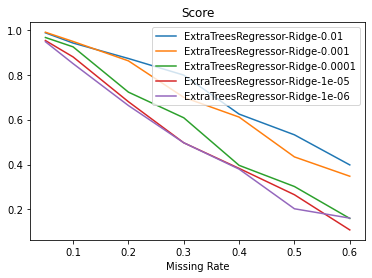

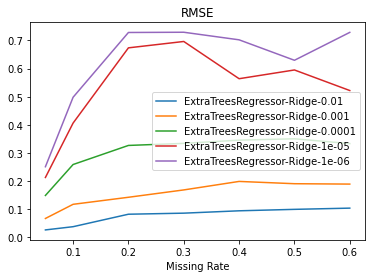

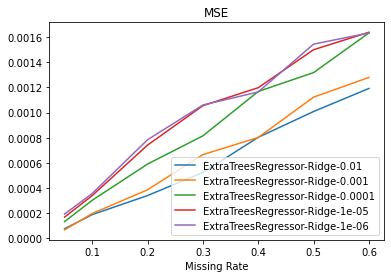

In [46]:
#br_estimator_list = 
#impute_estimator_list =
alpha_list = [0.01, 0.001, 0.0001, 0.00001, 0.000001]
missing_rate_list=[0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
#missing_rate_list=[0.005, 0.01, 0.05, 0.1, 0.2, 0.25, 0.3, 0.35, 0.4]
#alpha_list = [0.0001]
#missing_rate_list=[0.005]
poly=1
score_dict={}
rmse_dict={}
mse_dict={}
for a in alpha_list:
    #br_estimator = Lasso(alpha=a)
    #impute_estimator =Lasso(alpha=a)
    #br_estimator = Ridge(alpha=a)
    impute_estimator =Ridge(alpha=a)
    br_estimator = ExtraTreesRegressor(n_estimators=10, random_state=0)
    #impute_estimator =Lasso(alpha=a)
    score_list=[]
    rmse_list=[]
    mse_list=[]
    for missing_rate in missing_rate_list:
        y_missing = l_m
        X_m, X_missing, data_m=missing_data(missing_rate,X_m)
        estimator, score, rmse, mse = train_missing_pipeline(br_estimator, impute_estimator, X_missing, l_m, y_missing, data_m, poly)
        score_list.append(score)
        rmse_list.append(rmse)
        mse_list.append(mse)
    legend_key=str(br_estimator).split('(')[0]+'-'+ str(impute_estimator).split('(')[0]+'-'+str(a)
    score_dict[legend_key]=score_list
    rmse_dict[legend_key]=rmse_list
    mse_dict[legend_key]=mse_list
plot_fig(missing_rate_list,score_dict,rmse_dict,mse_dict,"_ridge_"+str(poly))

0.9829441867405778, 0.04954594521859722, 9.973439317082485e-05
0.9497535473761203, 0.048710718498264104, 0.00020203193156130808
0.8674596365145386, 0.06502851530361638, 0.00033608242532157475
0.7768956962934153, 0.09082467012681399, 0.000598495482785704
0.6419975976712659, 0.09298699650421113, 0.0007366425609414999
0.5419130690828328, 0.10250212787147614, 0.000990823065511089
0.35129441983511783, 0.10456545613028938, 0.0012838127365251974


/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00238137905301522, tolerance: 0.0004192061702396337
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011806632380621462, tolerance: 0.0005923083495688394
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009694286730875523, tolerance: 0.0004211011536936326
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/s

0.974808482316248, 0.033272073305991495, 0.00010166413868628477


/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00238137905301522, tolerance: 0.0004192061702396337
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011806632380621462, tolerance: 0.0005923083495688394
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009694286730875523, tolerance: 0.0004211011536936326
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/s

0.9486265904801041, 0.04980456406969491, 0.000170370721565063


/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00238137905301522, tolerance: 0.0004192061702396337
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011806632380621462, tolerance: 0.0005923083495688394
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009694286730875523, tolerance: 0.0004211011536936326
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/s

0.8733732953238903, 0.05116470918888228, 0.00031577039516641987


/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00238137905301522, tolerance: 0.0004192061702396337
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011806632380621462, tolerance: 0.0005923083495688394
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009694286730875523, tolerance: 0.0004211011536936326
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/s

0.7704785817566456, 0.06115979524740858, 0.0005439297684001406


/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00238137905301522, tolerance: 0.0004192061702396337
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011806632380621462, tolerance: 0.0005923083495688394
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009694286730875523, tolerance: 0.0004211011536936326
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/s

0.6750567796269626, 0.06891307416138803, 0.0006626678794619922


/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00238137905301522, tolerance: 0.0004192061702396337
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011806632380621462, tolerance: 0.0005923083495688394
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009694286730875523, tolerance: 0.0004211011536936326
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/s

0.5453335175011158, 0.07563424487765713, 0.0009639427323283596


/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00238137905301522, tolerance: 0.0004192061702396337
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011806632380621462, tolerance: 0.0005923083495688394
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009694286730875523, tolerance: 0.0004211011536936326
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/s

0.3669770284339519, 0.08497959544403913, 0.001160201300431254
0.9842720065951319, 0.04902254371181126, 8.165340845125323e-05
0.9723953652593443, 0.04834006379439235, 0.0001557202227550803
0.8806791157899511, 0.05833436937051306, 0.00035658999790644073
0.8068066754566333, 0.06391989758035987, 0.0005139979586210794
0.6636411876520165, 0.07551042762327953, 0.0007950668430967581
0.5066759155787379, 0.07728760477158776, 0.0009631217646346049
0.3854962857690714, 0.08616049360486001, 0.0012324797610141643
0.98173488036012, 0.05999651312404565, 0.00010562211839702
0.9613336542607303, 0.06058461036410321, 0.00023577725044703375
0.8705746707624507, 0.05624807381499988, 0.00043668082103125465
0.8182147630720867, 0.06625223345301026, 0.0006417602963749723
0.7478988326502242, 0.07987748441144132, 0.0007795697138927466
0.6544709732220721, 0.096947101371546, 0.0011203913599167664
0.5077808029640575, 0.09856155035307473, 0.0012724916515430642
0.9923445320583781, 0.007717970731568085, 3.019865136942658

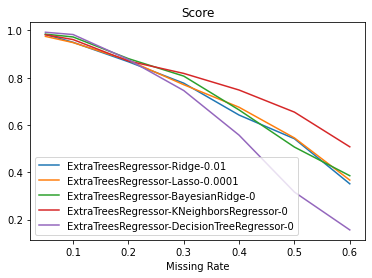

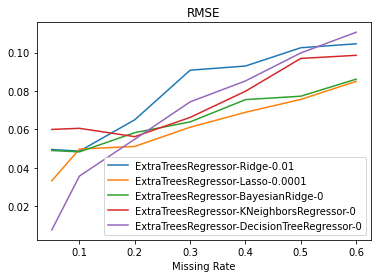

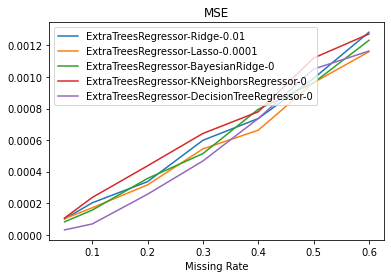

In [47]:
#br_estimator_list = 
impute_estimator_list = [Ridge(alpha=0.01),
                         Lasso(alpha=0.0001), 
                         BayesianRidge(),
                         KNeighborsRegressor(),
                         DecisionTreeRegressor(max_features='auto', random_state=0)
                        ]
missing_rate_list=[0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
poly=1
score_dict={}
rmse_dict={}
mse_dict={}
br_estimator = ExtraTreesRegressor(n_estimators=10, random_state=0)
i=0
alpha=[0.01,0.0001,0,0,0]
for i_e in impute_estimator_list:
    impute_estimator = i_e
    score_list=[]
    rmse_list=[]
    mse_list=[]
    for missing_rate in missing_rate_list:
        y_missing = l_m
        X_m, X_missing, data_m=missing_data(missing_rate,X_m)
        estimator, score, rmse, mse = train_missing_pipeline(br_estimator, impute_estimator, X_missing, l_m, y_missing, data_m, poly)
        score_list.append(score)
        rmse_list.append(rmse)
        mse_list.append(mse)
    a=alpha[i]
    legend_key=str(br_estimator).split('(')[0]+'-'+ str(impute_estimator).split('(')[0]+'-'+str(a)
    score_dict[legend_key]=score_list
    rmse_dict[legend_key]=rmse_list
    mse_dict[legend_key]=mse_list
    i=i+1
y_label=["Score","RMSE","MSE"]
plot_fig(missing_rate_list,score_dict,rmse_dict,mse_dict,str(poly),"Missing Rate",x_label,y_label)

/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00238137905301522, tolerance: 0.0004192061702396337
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011806632380621462, tolerance: 0.0005923083495688394
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009694286730875523, tolerance: 0.0004211011536936326
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/s

0.8474315403549327, 0.036297615381748145, 0.00036968131398204426


/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00238137905301522, tolerance: 0.0004192061702396337
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011806632380621462, tolerance: 0.0005923083495688394
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009694286730875523, tolerance: 0.0004211011536936326
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/s

0.8049251562594865, 0.05086106956406633, 0.00042684598623276795


/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00238137905301522, tolerance: 0.0004192061702396337
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011806632380621462, tolerance: 0.0005923083495688394
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009694286730875523, tolerance: 0.0004211011536936326
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/s

0.4374352253884467, 0.05640211681420669, 0.0007547747852539628


/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00238137905301522, tolerance: 0.0004192061702396337
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011806632380621462, tolerance: 0.0005923083495688394
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009694286730875523, tolerance: 0.0004211011536936326
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/s

0.15195783267472737, 0.06112463075042943, 0.00099577257739972


/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00238137905301522, tolerance: 0.0004192061702396337
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011806632380621462, tolerance: 0.0005923083495688394
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009694286730875523, tolerance: 0.0004211011536936326
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/s

-0.03648701643199431, 0.0676120521984939, 0.0011285397070660691


/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00238137905301522, tolerance: 0.0004192061702396337
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011806632380621462, tolerance: 0.0005923083495688394
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009694286730875523, tolerance: 0.0004211011536936326
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/s

-0.6615370785448949, 0.07772469915460398, 0.0015284364231637974


/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00238137905301522, tolerance: 0.0004192061702396337
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011806632380621462, tolerance: 0.0005923083495688394
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009694286730875523, tolerance: 0.0004211011536936326
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/s

-0.8610058663362598, 0.08351123343329077, 0.0016615977981138301


/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00238137905301522, tolerance: 0.0004192061702396337
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011806632380621462, tolerance: 0.0005923083495688394
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009694286730875523, tolerance: 0.0004211011536936326
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/s

0.7912213632660182, 0.038909191360176974, 0.000413464811088776


/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00238137905301522, tolerance: 0.0004192061702396337
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011806632380621462, tolerance: 0.0005923083495688394
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009694286730875523, tolerance: 0.0004211011536936326
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/s

0.6296637100644646, 0.03868229336427381, 0.000568791967371726


/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00238137905301522, tolerance: 0.0004192061702396337
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011806632380621462, tolerance: 0.0005923083495688394
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009694286730875523, tolerance: 0.0004211011536936326
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/s

-0.21829314893502352, 0.05851227753285789, 0.0011158313273504723


/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00238137905301522, tolerance: 0.0004192061702396337
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011806632380621462, tolerance: 0.0005923083495688394
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009694286730875523, tolerance: 0.0004211011536936326
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/s

-1.2259433731014635, 0.059325648350639325, 0.001430505851692399


/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00238137905301522, tolerance: 0.0004192061702396337
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011806632380621462, tolerance: 0.0005923083495688394
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009694286730875523, tolerance: 0.0004211011536936326
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/s

-1.5600503324369717, 0.0618651020010494, 0.0015675449157509776


/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00238137905301522, tolerance: 0.0004192061702396337
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011806632380621462, tolerance: 0.0005923083495688394
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009694286730875523, tolerance: 0.0004211011536936326
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/s

-3.446321649564925, 0.07349617120446075, 0.002122692546014559


/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00238137905301522, tolerance: 0.0004192061702396337
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011806632380621462, tolerance: 0.0005923083495688394
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009694286730875523, tolerance: 0.0004211011536936326
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/s

-4.0229284192108175, 0.08050076399678929, 0.0023825835360073632


/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00238137905301522, tolerance: 0.0004192061702396337
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011806632380621462, tolerance: 0.0005923083495688394
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009694286730875523, tolerance: 0.0004211011536936326
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/s

0.1762925497700246, 0.025645164620734674, 0.0010779141250938614


/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00238137905301522, tolerance: 0.0004192061702396337
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011806632380621462, tolerance: 0.0005923083495688394
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009694286730875523, tolerance: 0.0004211011536936326
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/s

0.17491595550055986, 0.04340325677575934, 0.0010805811878750271


/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00238137905301522, tolerance: 0.0004192061702396337
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011806632380621462, tolerance: 0.0005923083495688394
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009694286730875523, tolerance: 0.0004211011536936326
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/s

0.1730109409886904, 0.04862255471095591, 0.001117448024650215


/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00238137905301522, tolerance: 0.0004192061702396337
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011806632380621462, tolerance: 0.0005923083495688394
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009694286730875523, tolerance: 0.0004211011536936326
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/s

0.16942867072866521, 0.05853646210738266, 0.0011619200193677866


/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00238137905301522, tolerance: 0.0004192061702396337
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011806632380621462, tolerance: 0.0005923083495688394
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009694286730875523, tolerance: 0.0004211011536936326
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/s

0.15749634399140522, 0.0707224357783839, 0.001290215652122751


/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00238137905301522, tolerance: 0.0004192061702396337
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011806632380621462, tolerance: 0.0005923083495688394
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009694286730875523, tolerance: 0.0004211011536936326
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/s

0.15879543613980926, 0.07041765826635019, 0.0012835129547424848


/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00238137905301522, tolerance: 0.0004192061702396337
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011806632380621462, tolerance: 0.0005923083495688394
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009694286730875523, tolerance: 0.0004211011536936326
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/s

0.13811539110246843, 0.08558110191245863, 0.0014454230000475264


/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00238137905301522, tolerance: 0.0004192061702396337
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011806632380621462, tolerance: 0.0005923083495688394
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009694286730875523, tolerance: 0.0004211011536936326
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/s

0.46651677587401374, 0.03849212571070936, 0.0007252089932328342


/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00238137905301522, tolerance: 0.0004192061702396337
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011806632380621462, tolerance: 0.0005923083495688394
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009694286730875523, tolerance: 0.0004211011536936326
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/s

0.46031557071415424, 0.03808489446341834, 0.000735158182108437


/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00238137905301522, tolerance: 0.0004192061702396337
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011806632380621462, tolerance: 0.0005923083495688394
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009694286730875523, tolerance: 0.0004211011536936326
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/s

0.41348583609815565, 0.054909705004319354, 0.0008084654804550556


/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00238137905301522, tolerance: 0.0004192061702396337
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011806632380621462, tolerance: 0.0005923083495688394
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009694286730875523, tolerance: 0.0004211011536936326
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/s

0.3517322905088413, 0.06519750489417736, 0.0008795403279335047


/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00238137905301522, tolerance: 0.0004192061702396337
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011806632380621462, tolerance: 0.0005923083495688394
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009694286730875523, tolerance: 0.0004211011536936326
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/s

0.3092878871246625, 0.07124025602733824, 0.0010226684241592314


/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00238137905301522, tolerance: 0.0004192061702396337
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011806632380621462, tolerance: 0.0005923083495688394
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009694286730875523, tolerance: 0.0004211011536936326
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/s

0.2571677414606106, 0.07364970712431103, 0.0011731489951749441


/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00238137905301522, tolerance: 0.0004192061702396337
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011806632380621462, tolerance: 0.0005923083495688394
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009694286730875523, tolerance: 0.0004211011536936326
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/s

0.15934973270064046, 0.08715892011850468, 0.0013529843705523976


/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00238137905301522, tolerance: 0.0004192061702396337
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011806632380621462, tolerance: 0.0005923083495688394
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009694286730875523, tolerance: 0.0004211011536936326
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/s

0.9739817672025096, 0.036905046022830644, 0.00011111011782446394


/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00238137905301522, tolerance: 0.0004192061702396337
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011806632380621462, tolerance: 0.0005923083495688394
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009694286730875523, tolerance: 0.0004211011536936326
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/s

0.9394551621554066, 0.04760901765349407, 0.00018803908956319302


/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00238137905301522, tolerance: 0.0004192061702396337
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011806632380621462, tolerance: 0.0005923083495688394
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009694286730875523, tolerance: 0.0004211011536936326
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/s

0.8753891833262927, 0.04033499264005587, 0.00030579520326362434


/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00238137905301522, tolerance: 0.0004192061702396337
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011806632380621462, tolerance: 0.0005923083495688394
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009694286730875523, tolerance: 0.0004211011536936326
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/s

0.777553202187625, 0.05797975063352371, 0.0005595715726763671


/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00238137905301522, tolerance: 0.0004192061702396337
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011806632380621462, tolerance: 0.0005923083495688394
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009694286730875523, tolerance: 0.0004211011536936326
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/s

0.6503191444663798, 0.07010013655545842, 0.0007525326216927669


/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00238137905301522, tolerance: 0.0004192061702396337
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011806632380621462, tolerance: 0.0005923083495688394
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009694286730875523, tolerance: 0.0004211011536936326
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/s

0.5487748016621958, 0.07480664934664534, 0.0009689602126003608


/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00238137905301522, tolerance: 0.0004192061702396337
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011806632380621462, tolerance: 0.0005923083495688394
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009694286730875523, tolerance: 0.0004211011536936326
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/s

0.3883020376917961, 0.08176461054888563, 0.0011164732746775444


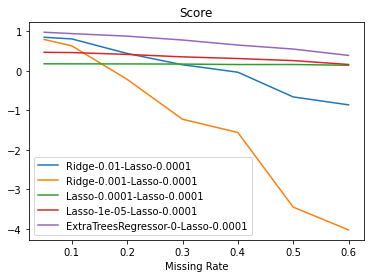

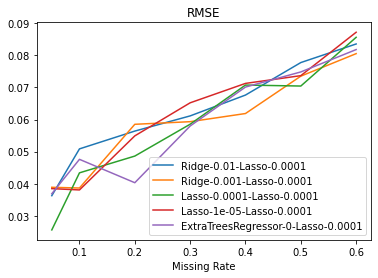

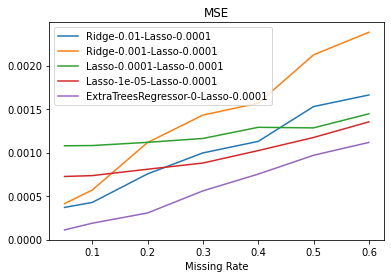

In [50]:
br_estimator_list = [Ridge(alpha=0.01),
                     Ridge(alpha=0.001),
                     Lasso(alpha=0.0001),
                     Lasso(alpha=0.00001),
                     ExtraTreesRegressor(n_estimators=10, random_state=0)
                     ]
impute_estimator_list = [Lasso(alpha=0.0001)
                        ]
missing_rate_list=[0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
poly=1
score_dict={}
rmse_dict={}
mse_dict={}
br_estimator = ExtraTreesRegressor(n_estimators=10, random_state=0)
i=0
alpha=[0.01,0.001,0.0001,0.00001,0]
beta=[0.0001]
for b_e in br_estimator_list:
    br_estimator=b_e
    a=alpha[i]
    j=0
    for i_e in impute_estimator_list:
        b=beta[j]
        impute_estimator = i_e
        score_list=[]
        rmse_list=[]
        mse_list=[]
        for missing_rate in missing_rate_list:
            y_missing = l_m
            X_m, X_missing, data_m=missing_data(missing_rate,X_m)
            estimator, score, rmse, mse = train_missing_pipeline(br_estimator, impute_estimator, X_missing, l_m, y_missing, data_m, poly)
            score_list.append(score)
            rmse_list.append(rmse)
            mse_list.append(mse)
        a=alpha[i]
        legend_key=str(br_estimator).split('(')[0]+'-'+str(a)+'-'+ str(impute_estimator).split('(')[0]+'-'+str(b)
        score_dict[legend_key]=score_list
        rmse_dict[legend_key]=rmse_list
        mse_dict[legend_key]=mse_list
        j=j+1
    i=i+1
y_label=["Score","RMSE","MSE"]
plot_fig(missing_rate_list,score_dict,rmse_dict,mse_dict,"br"+str(poly),"Missing Rate", y_label)

In [59]:
def plot_fig(missing_rate_list,score_dict,rmse_dict,mse_dict,tag,x_label,y_label):
    fig1, ax1 = plt.subplots()
    ax1.set_title(y_label[0])
    ax1.set_xlabel(x_label)
    for key in score_dict.keys():
        ax1.plot(missing_rate_list,score_dict[key], label = str(key))

    plt.legend()
    name=y_label[0]+tag+".png"
    plt.savefig(name, bbox_inches='tight')

    fig2, ax2 = plt.subplots()
    ax2.set_title(y_label[1])
    ax2.set_xlabel(x_label)
    for key in rmse_dict.keys():
        ax2.plot(missing_rate_list,rmse_dict[key], label = str(key))

    plt.legend()
    name=y_label[1]+tag+".png"
    plt.savefig(name, bbox_inches='tight')
    
    fig3, ax3 = plt.subplots()
    ax3.set_title(y_label[2])
    ax3.set_xlabel(x_label)
    for key in mse_dict.keys():
        ax3.plot(missing_rate_list,mse_dict[key], label = str(key))

    plt.legend()
    name=y_label[2]+tag+".png"
    plt.savefig(name, bbox_inches='tight')


In [60]:
def test_missing_pipeline(br_estimator, impute_estimator, X_missing, l_m, y_missing, poly):
    estimator = make_pipeline(
        IterativeImputer(random_state=0, missing_values=np.nan, estimator=impute_estimator),
        PolynomialFeatures(poly),
        br_estimator
    )

    estimator.fit(X_m, l_m)
    score = estimator.score(X_missing, y_missing)
    y_hat=estimator.predict(X_missing)
    
    imu = estimator['iterativeimputer']
    X_m_impute=imu.transform(X_missing)

    mse=mean_squared_error(y_missing, y_hat,squared=False)
    print("%s, %s"% (score,mse))
    
    return estimator, score, mse, y_hat

/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00238137905301522, tolerance: 0.0004192061702396337
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011806632380621462, tolerance: 0.0005923083495688394
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009694286730875523, tolerance: 0.0004211011536936326
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/s

0.743603175782015, 0.0004972785723291396
(261, 87), (261, 87), num:87 num-k:83
0.74360:0.00050 --247


/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00238137905301522, tolerance: 0.0004192061702396337
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011806632380621462, tolerance: 0.0005923083495688394
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009694286730875523, tolerance: 0.0004211011536936326
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/s

0.7154998341931363, 0.0005369390662763345
(261, 87), (261, 87), num:87 num-k:83
0.71550:0.00054 --245


/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00238137905301522, tolerance: 0.0004192061702396337
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011806632380621462, tolerance: 0.0005923083495688394
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009694286730875523, tolerance: 0.0004211011536936326
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/s

0.5987260881972193, 0.0006619421019953594
(261, 87), (261, 87), num:87 num-k:83
0.59873:0.00066 --236


/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00238137905301522, tolerance: 0.0004192061702396337
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011806632380621462, tolerance: 0.0005923083495688394
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009694286730875523, tolerance: 0.0004211011536936326
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/s

0.5016069110204697, 0.0008057326591243547
(261, 87), (261, 87), num:87 num-k:83
0.50161:0.00081 --227


/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00238137905301522, tolerance: 0.0004192061702396337
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011806632380621462, tolerance: 0.0005923083495688394
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009694286730875523, tolerance: 0.0004211011536936326
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/s

0.42051816073331727, 0.0008998743361847697
(261, 87), (261, 87), num:87 num-k:83
0.42052:0.00090 --212


/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00238137905301522, tolerance: 0.0004192061702396337
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011806632380621462, tolerance: 0.0005923083495688394
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009694286730875523, tolerance: 0.0004211011536936326
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/s

0.06431265939449775, 0.001221105044690091
(261, 87), (261, 87), num:87 num-k:83
0.06431:0.00122 --201


/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00238137905301522, tolerance: 0.0004192061702396337
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011806632380621462, tolerance: 0.0005923083495688394
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009694286730875523, tolerance: 0.0004211011536936326
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/s

0.0006449902194381316, 0.001416764236268997
(261, 87), (261, 87), num:87 num-k:83
0.00064:0.00142 --181


/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00238137905301522, tolerance: 0.0004192061702396337
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011806632380621462, tolerance: 0.0005923083495688394
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009694286730875523, tolerance: 0.0004211011536936326
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/s

0.8475578580902362, 0.000365334311360969
(261, 87), (261, 87), num:87 num-k:83
0.84756:0.00037 --255


/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00238137905301522, tolerance: 0.0004192061702396337
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011806632380621462, tolerance: 0.0005923083495688394
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009694286730875523, tolerance: 0.0004211011536936326
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/s

0.7454747631853652, 0.0004990732640934239
(261, 87), (261, 87), num:87 num-k:83
0.74547:0.00050 --249


/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00238137905301522, tolerance: 0.0004192061702396337
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011806632380621462, tolerance: 0.0005923083495688394
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009694286730875523, tolerance: 0.0004211011536936326
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/s

0.6292869455425129, 0.0006243935993771091
(261, 87), (261, 87), num:87 num-k:83
0.62929:0.00062 --244


/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00238137905301522, tolerance: 0.0004192061702396337
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011806632380621462, tolerance: 0.0005923083495688394
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009694286730875523, tolerance: 0.0004211011536936326
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/s

0.19870679020351245, 0.0009920576346407726
(261, 87), (261, 87), num:87 num-k:83
0.19871:0.00099 --237


/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00238137905301522, tolerance: 0.0004192061702396337
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011806632380621462, tolerance: 0.0005923083495688394
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009694286730875523, tolerance: 0.0004211011536936326
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/s

-0.12639837919056346, 0.001212065390685547
(261, 87), (261, 87), num:87 num-k:83
-0.12640:0.00121 --225


/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00238137905301522, tolerance: 0.0004192061702396337
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011806632380621462, tolerance: 0.0005923083495688394
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009694286730875523, tolerance: 0.0004211011536936326
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/s

-0.6734640168842794, 0.0015391422714208175
(261, 87), (261, 87), num:87 num-k:83
-0.67346:0.00154 --212


/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00238137905301522, tolerance: 0.0004192061702396337
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011806632380621462, tolerance: 0.0005923083495688394
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009694286730875523, tolerance: 0.0004211011536936326
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/s

-0.9390898539732173, 0.0017317568822738574
(261, 87), (261, 87), num:87 num-k:83
-0.93909:0.00173 --189


/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00238137905301522, tolerance: 0.0004192061702396337
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011806632380621462, tolerance: 0.0005923083495688394
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009694286730875523, tolerance: 0.0004211011536936326
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/s

0.4701473122173023, 0.0007187455530915512
(261, 87), (261, 87), num:87 num-k:83
0.47015:0.00072 --132


/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00238137905301522, tolerance: 0.0004192061702396337
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011806632380621462, tolerance: 0.0005923083495688394
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009694286730875523, tolerance: 0.0004211011536936326
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/s

0.46317968382499203, 0.0007436032710476298
(261, 87), (261, 87), num:87 num-k:83
0.46318:0.00074 --133


/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00238137905301522, tolerance: 0.0004192061702396337
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011806632380621462, tolerance: 0.0005923083495688394
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009694286730875523, tolerance: 0.0004211011536936326
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/s

0.42843784336274, 0.0007853038269256469
(261, 87), (261, 87), num:87 num-k:83
0.42844:0.00079 --128


/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00238137905301522, tolerance: 0.0004192061702396337
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011806632380621462, tolerance: 0.0005923083495688394
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009694286730875523, tolerance: 0.0004211011536936326
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/s

0.39084974693934493, 0.0008477729799066855
(261, 87), (261, 87), num:87 num-k:83
0.39085:0.00085 --115


/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00238137905301522, tolerance: 0.0004192061702396337
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011806632380621462, tolerance: 0.0005923083495688394
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009694286730875523, tolerance: 0.0004211011536936326
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/s

0.3067048383504382, 0.0009981717433076023
(261, 87), (261, 87), num:87 num-k:83
0.30670:0.00100 --111


/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00238137905301522, tolerance: 0.0004192061702396337
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011806632380621462, tolerance: 0.0005923083495688394
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009694286730875523, tolerance: 0.0004211011536936326
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/s

0.24163873800806132, 0.0011425373580342365
(261, 87), (261, 87), num:87 num-k:83
0.24164:0.00114 --107


/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00238137905301522, tolerance: 0.0004192061702396337
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011806632380621462, tolerance: 0.0005923083495688394
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009694286730875523, tolerance: 0.0004211011536936326
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/s

0.18043853264112258, 0.0013024620480869152
(261, 87), (261, 87), num:87 num-k:83
0.18044:0.00130 --99


/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00238137905301522, tolerance: 0.0004192061702396337
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011806632380621462, tolerance: 0.0005923083495688394
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009694286730875523, tolerance: 0.0004211011536936326
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/s

/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.73069026770169e-08, tolerance: 8.470319955961293e-09
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.896894020100681e-07, tolerance: 9.439563403228736e-09
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.320907657670575e-08, tolerance: 3.010000085031815e-08
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages

/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.173116006773539e-08, tolerance: 2.9114139589302493e-08
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3414186811221308e-08, tolerance: 9.125191677614313e-09
  model = cd_fast.enet_coordinate_descent(


0.7324858912600277, 0.0004768469482920179
(261, 87), (261, 87), num:87 num-k:83
0.73249:0.00048 --221


/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00238137905301522, tolerance: 0.0004192061702396337
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011806632380621462, tolerance: 0.0005923083495688394
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009694286730875523, tolerance: 0.0004211011536936326
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/s

/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.896894020100681e-07, tolerance: 9.439563403228736e-09
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.320907657670575e-08, tolerance: 3.010000085031815e-08
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2649371403331152e-07, tolerance: 4.5008018402618464e-08
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packa

0.6975398424255237, 0.0005315388324501788
(261, 87), (261, 87), num:87 num-k:83
0.69754:0.00053 --221


/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00238137905301522, tolerance: 0.0004192061702396337
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011806632380621462, tolerance: 0.0005923083495688394
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009694286730875523, tolerance: 0.0004211011536936326
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/s

/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.896894020100681e-07, tolerance: 9.439563403228736e-09
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.320907657670575e-08, tolerance: 3.010000085031815e-08
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2649371403331152e-07, tolerance: 4.5008018402618464e-08
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packa

0.6012494911704488, 0.0006496377931897555
(261, 87), (261, 87), num:87 num-k:83
0.60125:0.00065 --212


/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00238137905301522, tolerance: 0.0004192061702396337
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011806632380621462, tolerance: 0.0005923083495688394
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009694286730875523, tolerance: 0.0004211011536936326
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/s

/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.73069026770169e-08, tolerance: 8.470319955961293e-09
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.896894020100681e-07, tolerance: 9.439563403228736e-09
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.320907657670575e-08, tolerance: 3.010000085031815e-08
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages

/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.173116006773539e-08, tolerance: 2.9114139589302493e-08
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3414186811221308e-08, tolerance: 9.125191677614313e-09
  model = cd_fast.enet_coordinate_descent(


0.37786172585646005, 0.0009346025855895827
(261, 87), (261, 87), num:87 num-k:83
0.37786:0.00093 --209


/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00238137905301522, tolerance: 0.0004192061702396337
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011806632380621462, tolerance: 0.0005923083495688394
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009694286730875523, tolerance: 0.0004211011536936326
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/s

/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.73069026770169e-08, tolerance: 8.470319955961293e-09
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.896894020100681e-07, tolerance: 9.439563403228736e-09
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.320907657670575e-08, tolerance: 3.010000085031815e-08
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages

/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.173116006773539e-08, tolerance: 2.9114139589302493e-08
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3414186811221308e-08, tolerance: 9.125191677614313e-09
  model = cd_fast.enet_coordinate_descent(


0.27626475268837625, 0.0010294290668614763
(261, 87), (261, 87), num:87 num-k:83
0.27626:0.00103 --188


/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00238137905301522, tolerance: 0.0004192061702396337
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011806632380621462, tolerance: 0.0005923083495688394
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009694286730875523, tolerance: 0.0004211011536936326
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/s

/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.896894020100681e-07, tolerance: 9.439563403228736e-09
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.320907657670575e-08, tolerance: 3.010000085031815e-08
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2649371403331152e-07, tolerance: 4.5008018402618464e-08
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packa

-0.020639608803422943, 0.001323277088570408
(261, 87), (261, 87), num:87 num-k:83
-0.02064:0.00132 --163


/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00238137905301522, tolerance: 0.0004192061702396337
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011806632380621462, tolerance: 0.0005923083495688394
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009694286730875523, tolerance: 0.0004211011536936326
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/s

/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.73069026770169e-08, tolerance: 8.470319955961293e-09
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.896894020100681e-07, tolerance: 9.439563403228736e-09
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.320907657670575e-08, tolerance: 3.010000085031815e-08
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages

/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.173116006773539e-08, tolerance: 2.9114139589302493e-08
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3414186811221308e-08, tolerance: 9.125191677614313e-09
  model = cd_fast.enet_coordinate_descent(


-0.1451853195684417, 0.001500148877584348
(261, 87), (261, 87), num:87 num-k:83
-0.14519:0.00150 --146


/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00238137905301522, tolerance: 0.0004192061702396337
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011806632380621462, tolerance: 0.0005923083495688394
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009694286730875523, tolerance: 0.0004211011536936326
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/s

0.9859724417962888, 8.714524108945245e-05
(261, 87), (261, 87), num:87 num-k:83
0.98597:0.00009 --261


/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00238137905301522, tolerance: 0.0004192061702396337
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011806632380621462, tolerance: 0.0005923083495688394
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009694286730875523, tolerance: 0.0004211011536936326
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/s

0.950470033766244, 0.00017276392060797173
(261, 87), (261, 87), num:87 num-k:83
0.95047:0.00017 --261


/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00238137905301522, tolerance: 0.0004192061702396337
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011806632380621462, tolerance: 0.0005923083495688394
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009694286730875523, tolerance: 0.0004211011536936326
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/s

0.8842146743944785, 0.00028308675613553796
(261, 87), (261, 87), num:87 num-k:83
0.88421:0.00028 --257


/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00238137905301522, tolerance: 0.0004192061702396337
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011806632380621462, tolerance: 0.0005923083495688394
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009694286730875523, tolerance: 0.0004211011536936326
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/s

0.7696263970385401, 0.0005334344707109052
(261, 87), (261, 87), num:87 num-k:83
0.76963:0.00053 --247


/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00238137905301522, tolerance: 0.0004192061702396337
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011806632380621462, tolerance: 0.0005923083495688394
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009694286730875523, tolerance: 0.0004211011536936326
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/s

0.6340321404634482, 0.0006610529049528619
(261, 87), (261, 87), num:87 num-k:83
0.63403:0.00066 --228


/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00238137905301522, tolerance: 0.0004192061702396337
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011806632380621462, tolerance: 0.0005923083495688394
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009694286730875523, tolerance: 0.0004211011536936326
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/s

0.5296915827915202, 0.0009691567249014009
(261, 87), (261, 87), num:87 num-k:83
0.52969:0.00097 --207


/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00238137905301522, tolerance: 0.0004192061702396337
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011806632380621462, tolerance: 0.0005923083495688394
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009694286730875523, tolerance: 0.0004211011536936326
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/s

0.343408836338352, 0.001236725661983457
(261, 87), (261, 87), num:87 num-k:83
0.34341:0.00124 --165


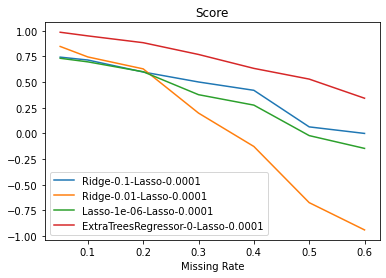

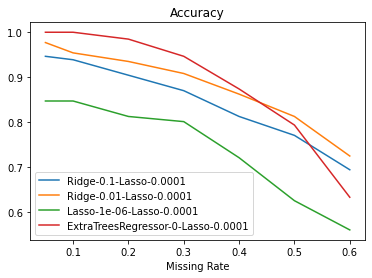

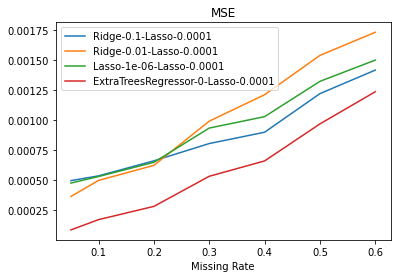

In [106]:
# Training missing test
br_estimator_list = [Ridge(alpha=0.1),
                     Ridge(alpha=0.01),
                     Lasso(alpha=0.00001),
                     Lasso(alpha=0.000001),
                     ExtraTreesRegressor(n_estimators=10, random_state=0)
                     ]
impute_estimator_list = [Lasso(alpha=0.0001)
                        ]

missing_rate_list=[0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]

score_dict={}
mse_dict={}
c_dict={}

i=0
k=4
alpha=[0.1,0.01,0.000001,0.000001,0]
beta=[0.0001]
for b_e in br_estimator_list:
    br_estimator=b_e
    a=alpha[i]
    j=0
    for i_e in impute_estimator_list:
        b=beta[j]
        impute_estimator = i_e
        score_list=[]
        c_list=[]
    
        mse_list=[]
        for missing_rate in missing_rate_list:
            
            y_missing = l_m
            X_m, X_missing, data_m=missing_data(missing_rate,X_m)
            
            estimator, score, mse, l_hat = test_missing_pipeline(br_estimator, impute_estimator, X_missing, l_m, y_missing, poly)
            
            score_list.append(score)

            mse_list.append(mse)
            
            sample=l_m.shape[0]
            num=l_m.shape[1]
            
            correct = accuracy_m(l_m, l_hat, k)
            #correct = accuracy_m(l_m[0:num], l_hat[0:num], k)
            #correct = accuracy_m(l_m[num:2*num], l_hat[num:2*num], k)

            print("%3.5f:%3.5f --%d" % (score, mse, correct))
            
            
            c_list.append(1.0*correct/sample)

            
        a=alpha[i]
        legend_key=str(br_estimator).split('(')[0]+'-'+str(a)+'-'+ str(impute_estimator).split('(')[0]+'-'+str(b)
        score_dict[legend_key]=score_list
        c_dict[legend_key]=c_list
        mse_dict[legend_key]=mse_list
        j=j+1
    i=i+1
y_label=["Score","Accuracy","MSE"]
plot_fig(missing_rate_list,score_dict,c_dict, mse_dict,"_test_train_"+str(k), "Missing Rate", y_label)



/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00238137905301522, tolerance: 0.0004192061702396337
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011806632380621462, tolerance: 0.0005923083495688394
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009694286730875523, tolerance: 0.0004211011536936326
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/s

-2.574475312747006, 0.0025094709225072466
(87, 87), (87, 87), num:87 num-k:86
(87, 87), (87, 87), num:87 num-k:86
(87, 87), (87, 87), num:87 num-k:86
8:15:13 ---- 87
-2.57448:0.00251 --


/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00238137905301522, tolerance: 0.0004192061702396337
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011806632380621462, tolerance: 0.0005923083495688394
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009694286730875523, tolerance: 0.0004211011536936326
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/s

-2.574475312747006, 0.0025094709225072466
(87, 87), (87, 87), num:87 num-k:85
(87, 87), (87, 87), num:87 num-k:85
(87, 87), (87, 87), num:87 num-k:85
10:20:20 ---- 87
-2.57448:0.00251 --


/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00238137905301522, tolerance: 0.0004192061702396337
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011806632380621462, tolerance: 0.0005923083495688394
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009694286730875523, tolerance: 0.0004211011536936326
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/s

-2.574475312747006, 0.0025094709225072466
(87, 87), (87, 87), num:87 num-k:84
(87, 87), (87, 87), num:87 num-k:84
(87, 87), (87, 87), num:87 num-k:84
10:20:22 ---- 87
-2.57448:0.00251 --


/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00238137905301522, tolerance: 0.0004192061702396337
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011806632380621462, tolerance: 0.0005923083495688394
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009694286730875523, tolerance: 0.0004211011536936326
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/s

-2.574475312747006, 0.0025094709225072466
(87, 87), (87, 87), num:87 num-k:83
(87, 87), (87, 87), num:87 num-k:83
(87, 87), (87, 87), num:87 num-k:83
11:25:25 ---- 87
-2.57448:0.00251 --


/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00238137905301522, tolerance: 0.0004192061702396337
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011806632380621462, tolerance: 0.0005923083495688394
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009694286730875523, tolerance: 0.0004211011536936326
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/s

-2.574475312747006, 0.0025094709225072466
(87, 87), (87, 87), num:87 num-k:82
(87, 87), (87, 87), num:87 num-k:82
(87, 87), (87, 87), num:87 num-k:82
15:27:27 ---- 87
-2.57448:0.00251 --


/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00238137905301522, tolerance: 0.0004192061702396337
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011806632380621462, tolerance: 0.0005923083495688394
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009694286730875523, tolerance: 0.0004211011536936326
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/s

-2.574475312747006, 0.0025094709225072466
(87, 87), (87, 87), num:87 num-k:81
(87, 87), (87, 87), num:87 num-k:81
(87, 87), (87, 87), num:87 num-k:81
16:28:30 ---- 87
-2.57448:0.00251 --


/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00238137905301522, tolerance: 0.0004192061702396337
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011806632380621462, tolerance: 0.0005923083495688394
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009694286730875523, tolerance: 0.0004211011536936326
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/s

-4.9981265509166715, 0.0026425622508513685
(87, 87), (87, 87), num:87 num-k:86
(87, 87), (87, 87), num:87 num-k:86
(87, 87), (87, 87), num:87 num-k:86
12:14:16 ---- 87
-4.99813:0.00264 --


/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00238137905301522, tolerance: 0.0004192061702396337
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011806632380621462, tolerance: 0.0005923083495688394
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009694286730875523, tolerance: 0.0004211011536936326
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/s

-4.9981265509166715, 0.0026425622508513685
(87, 87), (87, 87), num:87 num-k:85
(87, 87), (87, 87), num:87 num-k:85
(87, 87), (87, 87), num:87 num-k:85
16:23:23 ---- 87
-4.99813:0.00264 --


/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00238137905301522, tolerance: 0.0004192061702396337
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011806632380621462, tolerance: 0.0005923083495688394
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009694286730875523, tolerance: 0.0004211011536936326
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/s

-4.9981265509166715, 0.0026425622508513685
(87, 87), (87, 87), num:87 num-k:84
(87, 87), (87, 87), num:87 num-k:84
(87, 87), (87, 87), num:87 num-k:84
16:25:28 ---- 87
-4.99813:0.00264 --


/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00238137905301522, tolerance: 0.0004192061702396337
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011806632380621462, tolerance: 0.0005923083495688394
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009694286730875523, tolerance: 0.0004211011536936326
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/s

-4.9981265509166715, 0.0026425622508513685
(87, 87), (87, 87), num:87 num-k:83
(87, 87), (87, 87), num:87 num-k:83
(87, 87), (87, 87), num:87 num-k:83
21:26:30 ---- 87
-4.99813:0.00264 --


/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00238137905301522, tolerance: 0.0004192061702396337
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011806632380621462, tolerance: 0.0005923083495688394
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009694286730875523, tolerance: 0.0004211011536936326
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/s

-4.9981265509166715, 0.0026425622508513685
(87, 87), (87, 87), num:87 num-k:82
(87, 87), (87, 87), num:87 num-k:82
(87, 87), (87, 87), num:87 num-k:82
23:31:30 ---- 87
-4.99813:0.00264 --


/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00238137905301522, tolerance: 0.0004192061702396337
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011806632380621462, tolerance: 0.0005923083495688394
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009694286730875523, tolerance: 0.0004211011536936326
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/s

-4.9981265509166715, 0.0026425622508513685
(87, 87), (87, 87), num:87 num-k:81
(87, 87), (87, 87), num:87 num-k:81
(87, 87), (87, 87), num:87 num-k:81
26:33:32 ---- 87
-4.99813:0.00264 --


/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00238137905301522, tolerance: 0.0004192061702396337
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011806632380621462, tolerance: 0.0005923083495688394
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009694286730875523, tolerance: 0.0004211011536936326
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/s

-0.014737030399093368, 0.0024407326037118567
(87, 87), (87, 87), num:87 num-k:86
(87, 87), (87, 87), num:87 num-k:86
(87, 87), (87, 87), num:87 num-k:86
6:6:6 ---- 87
-0.01474:0.00244 --


/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00238137905301522, tolerance: 0.0004192061702396337
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011806632380621462, tolerance: 0.0005923083495688394
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009694286730875523, tolerance: 0.0004211011536936326
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/s

-0.014737030399093368, 0.0024407326037118567
(87, 87), (87, 87), num:87 num-k:85
(87, 87), (87, 87), num:87 num-k:85
(87, 87), (87, 87), num:87 num-k:85
7:7:7 ---- 87
-0.01474:0.00244 --


/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00238137905301522, tolerance: 0.0004192061702396337
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011806632380621462, tolerance: 0.0005923083495688394
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009694286730875523, tolerance: 0.0004211011536936326
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/s

-0.014737030399093368, 0.0024407326037118567
(87, 87), (87, 87), num:87 num-k:84
(87, 87), (87, 87), num:87 num-k:84
(87, 87), (87, 87), num:87 num-k:84
8:8:8 ---- 87
-0.01474:0.00244 --


/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00238137905301522, tolerance: 0.0004192061702396337
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011806632380621462, tolerance: 0.0005923083495688394
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009694286730875523, tolerance: 0.0004211011536936326
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/s

-0.014737030399093368, 0.0024407326037118567
(87, 87), (87, 87), num:87 num-k:83
(87, 87), (87, 87), num:87 num-k:83
(87, 87), (87, 87), num:87 num-k:83
8:8:8 ---- 87
-0.01474:0.00244 --


/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00238137905301522, tolerance: 0.0004192061702396337
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011806632380621462, tolerance: 0.0005923083495688394
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009694286730875523, tolerance: 0.0004211011536936326
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/s

-0.014737030399093368, 0.0024407326037118567
(87, 87), (87, 87), num:87 num-k:82
(87, 87), (87, 87), num:87 num-k:82
(87, 87), (87, 87), num:87 num-k:82
9:9:9 ---- 87
-0.01474:0.00244 --


/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00238137905301522, tolerance: 0.0004192061702396337
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011806632380621462, tolerance: 0.0005923083495688394
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009694286730875523, tolerance: 0.0004211011536936326
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/s

-0.014737030399093368, 0.0024407326037118567
(87, 87), (87, 87), num:87 num-k:81
(87, 87), (87, 87), num:87 num-k:81
(87, 87), (87, 87), num:87 num-k:81
9:9:9 ---- 87
-0.01474:0.00244 --


/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00238137905301522, tolerance: 0.0004192061702396337
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011806632380621462, tolerance: 0.0005923083495688394
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009694286730875523, tolerance: 0.0004211011536936326
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/s

-0.12737612122609132, 0.0023859101693724715
(87, 87), (87, 87), num:87 num-k:86
(87, 87), (87, 87), num:87 num-k:86
(87, 87), (87, 87), num:87 num-k:86
8:12:10 ---- 87
-0.12738:0.00239 --


/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00238137905301522, tolerance: 0.0004192061702396337
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011806632380621462, tolerance: 0.0005923083495688394
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009694286730875523, tolerance: 0.0004211011536936326
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/s

-0.12737612122609132, 0.0023859101693724715
(87, 87), (87, 87), num:87 num-k:85
(87, 87), (87, 87), num:87 num-k:85
(87, 87), (87, 87), num:87 num-k:85
10:16:18 ---- 87
-0.12738:0.00239 --


/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00238137905301522, tolerance: 0.0004192061702396337
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011806632380621462, tolerance: 0.0005923083495688394
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009694286730875523, tolerance: 0.0004211011536936326
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/s

-0.12737612122609132, 0.0023859101693724715
(87, 87), (87, 87), num:87 num-k:84
(87, 87), (87, 87), num:87 num-k:84
(87, 87), (87, 87), num:87 num-k:84
13:18:20 ---- 87
-0.12738:0.00239 --


/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00238137905301522, tolerance: 0.0004192061702396337
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011806632380621462, tolerance: 0.0005923083495688394
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009694286730875523, tolerance: 0.0004211011536936326
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/s

-0.12737612122609132, 0.0023859101693724715
(87, 87), (87, 87), num:87 num-k:83
(87, 87), (87, 87), num:87 num-k:83
(87, 87), (87, 87), num:87 num-k:83
16:23:27 ---- 87
-0.12738:0.00239 --


/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00238137905301522, tolerance: 0.0004192061702396337
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011806632380621462, tolerance: 0.0005923083495688394
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009694286730875523, tolerance: 0.0004211011536936326
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/s

-0.12737612122609132, 0.0023859101693724715
(87, 87), (87, 87), num:87 num-k:82
(87, 87), (87, 87), num:87 num-k:82
(87, 87), (87, 87), num:87 num-k:82
20:26:31 ---- 87
-0.12738:0.00239 --


/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00238137905301522, tolerance: 0.0004192061702396337
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011806632380621462, tolerance: 0.0005923083495688394
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009694286730875523, tolerance: 0.0004211011536936326
  model = cd_fast.enet_coordinate_descent(
/Users/yxin/opt/anaconda3/lib/python3.8/site-packages/s

-0.12737612122609132, 0.0023859101693724715
(87, 87), (87, 87), num:87 num-k:81
(87, 87), (87, 87), num:87 num-k:81
(87, 87), (87, 87), num:87 num-k:81
22:34:34 ---- 87
-0.12738:0.00239 --


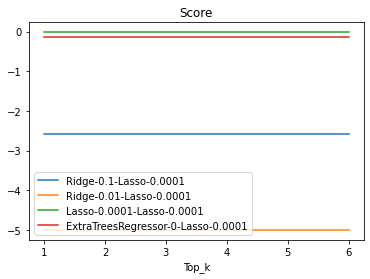

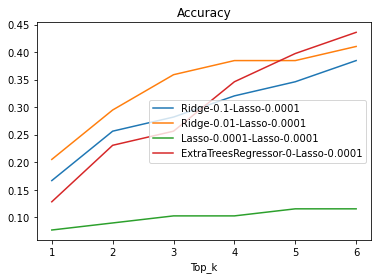

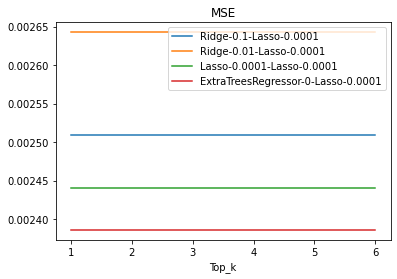

In [79]:
br_estimator_list = [Ridge(alpha=0.1),
                     Ridge(alpha=0.01),
                     Lasso(alpha=0.0001),
                     ExtraTreesRegressor(n_estimators=10, random_state=0)
                     ]
impute_estimator_list = [Lasso(alpha=0.0001)
                        ]

X_missing = X_p_m

t=3
nc=9
score_dict={}
mse_dict={}
c_1_dict={}
c_2_dict={}
c_3_dict={}

i=0
k_list=[1,2,3,4,5,6]
alpha=[0.1,0.01,0.0001,0]
beta=[0.0001]
for b_e in br_estimator_list:
    br_estimator=b_e
    a=alpha[i]
    j=0
    for i_e in impute_estimator_list:
        b=beta[j]
        impute_estimator = i_e
        score_list=[]
        c_1_list=[]
        c_2_list=[]
        c_3_list=[]
        mse_list=[]
        for k in k_list:
            l_p_m_t=np.copy(l_p_m) 
            l_p_m_t[np.isnan(l_p_m_t)] = l_m[np.isnan(l_p_m_t)]

            estimator, score, mse, l_hat = test_missing_pipeline(br_estimator, impute_estimator, X_missing, l_m, l_p_m_t, poly)
            
            score_list.append(score)

            mse_list.append(mse)
            
            num=l_hat.shape[1]
            correct1 = accuracy_m(l_p_m_t[0:num], l_hat[0:num], k)
            correct2 = accuracy_m(l_p_m_t[num:2*num], l_hat[num:2*num], k)
            correct3 = accuracy_m(l_p_m_t[2*num:3*num], l_hat[2*num:3*num], k)
            print("%d:%d:%d ---- %d" % (correct1, correct2, correct3, num))
            print("%3.5f:%3.5f --" % (score, mse))
            
            c_1_list.append(1.0*correct1/(num-nc))
            c_2_list.append(1.0*correct2/(num-nc))
            c_3_list.append(1.0*correct3/(num-nc))
            
        a=alpha[i]
        legend_key=str(br_estimator).split('(')[0]+'-'+str(a)+'-'+ str(impute_estimator).split('(')[0]+'-'+str(b)
        score_dict[legend_key]=score_list
        c_1_dict[legend_key]=c_1_list
        c_2_dict[legend_key]=c_2_list
        c_3_dict[legend_key]=c_3_list
        
        mse_dict[legend_key]=mse_list
        j=j+1
    i=i+1
y_label=["Score","Accuracy","MSE"]
plot_fig(k_list,score_dict,c_3_dict, mse_dict,"_test_nc_"+str(t), "Top_k", y_label)


In [107]:
np.savetxt('x_m.csv', X_m, delimiter=',')

In [75]:
X_missing=X_p_m
imu = estimator['iterativeimputer']
X_m_impute=imu.transform(X_missing)
rmse=rmse_loss(X_m,X_m_impute,data_m)
print(rmse)

l_p_m_t=np.copy(l_p_m) 
l_p_m_t[np.isnan(l_p_m_t)] = l_m[np.isnan(l_p_m_t)]
score=estimator.score(X_hat, l_p_m_t)
l_hat=estimator.predict(X_hat)

print("%s %s %s " % (l_p_m_t.shape, l_hat.shape, X_hat.shape))

mse=mean_squared_error(l_p_m_t, l_hat)
print("%s,%s"% (score,mse))

k=5
correct1 = accuracy_m(l_p_m_t[0:87], l_hat[0:87], k)
correct2 = accuracy_m(l_p_m_t[87:174], l_hat[87:174], k)
correct3 = accuracy_m(l_p_m_t[174:261], l_hat[174:261], k)
print("%d:%d:%d" % (correct1, correct2, correct3))

(261, 87) (261, 87) (261, 210) 
-0.5327671654606027,1.9190443421855123e-05
(87, 87), (87, 87), num:87 num-k:82
(87, 87), (87, 87), num:87 num-k:82
(87, 87), (87, 87), num:87 num-k:82
18:16:18
